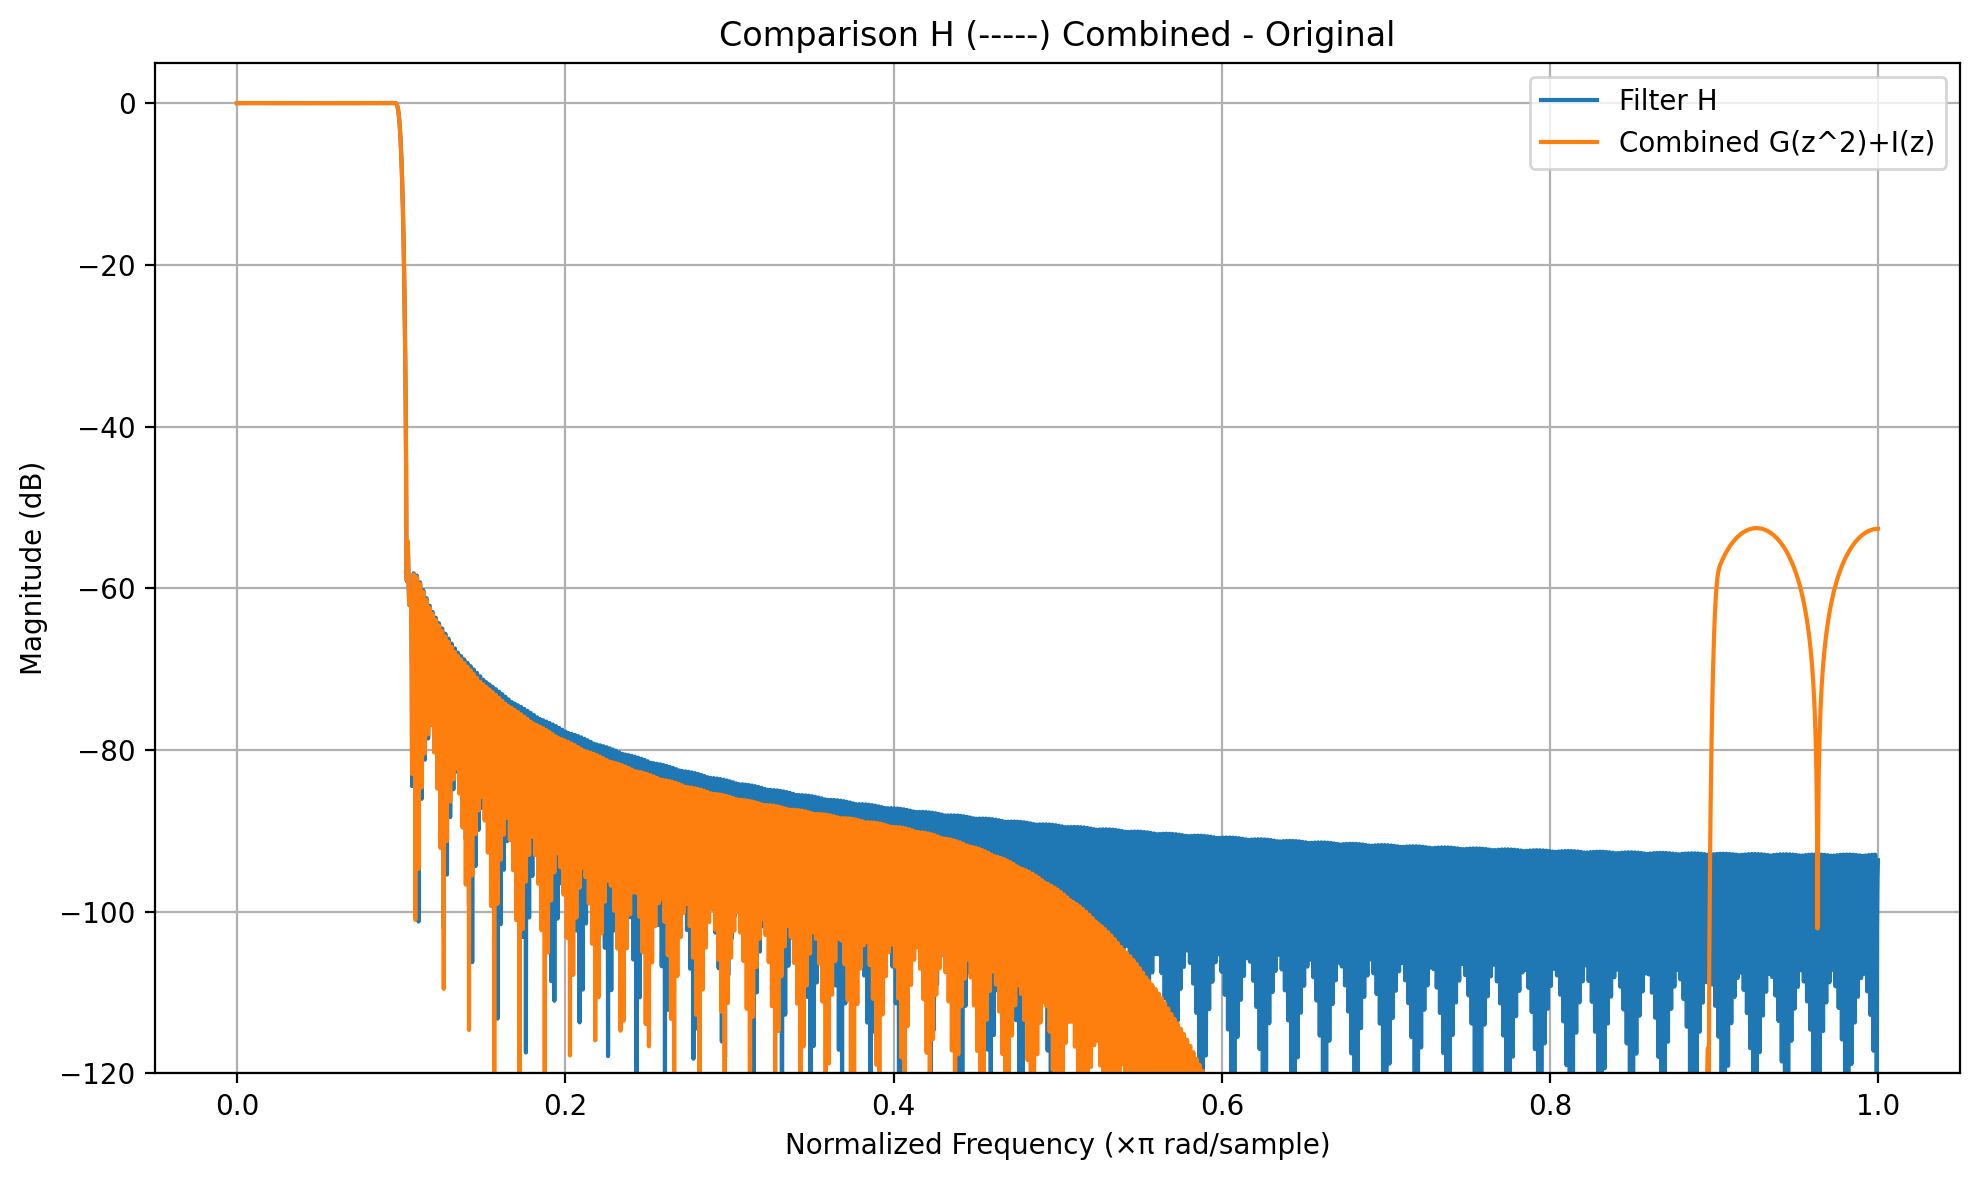

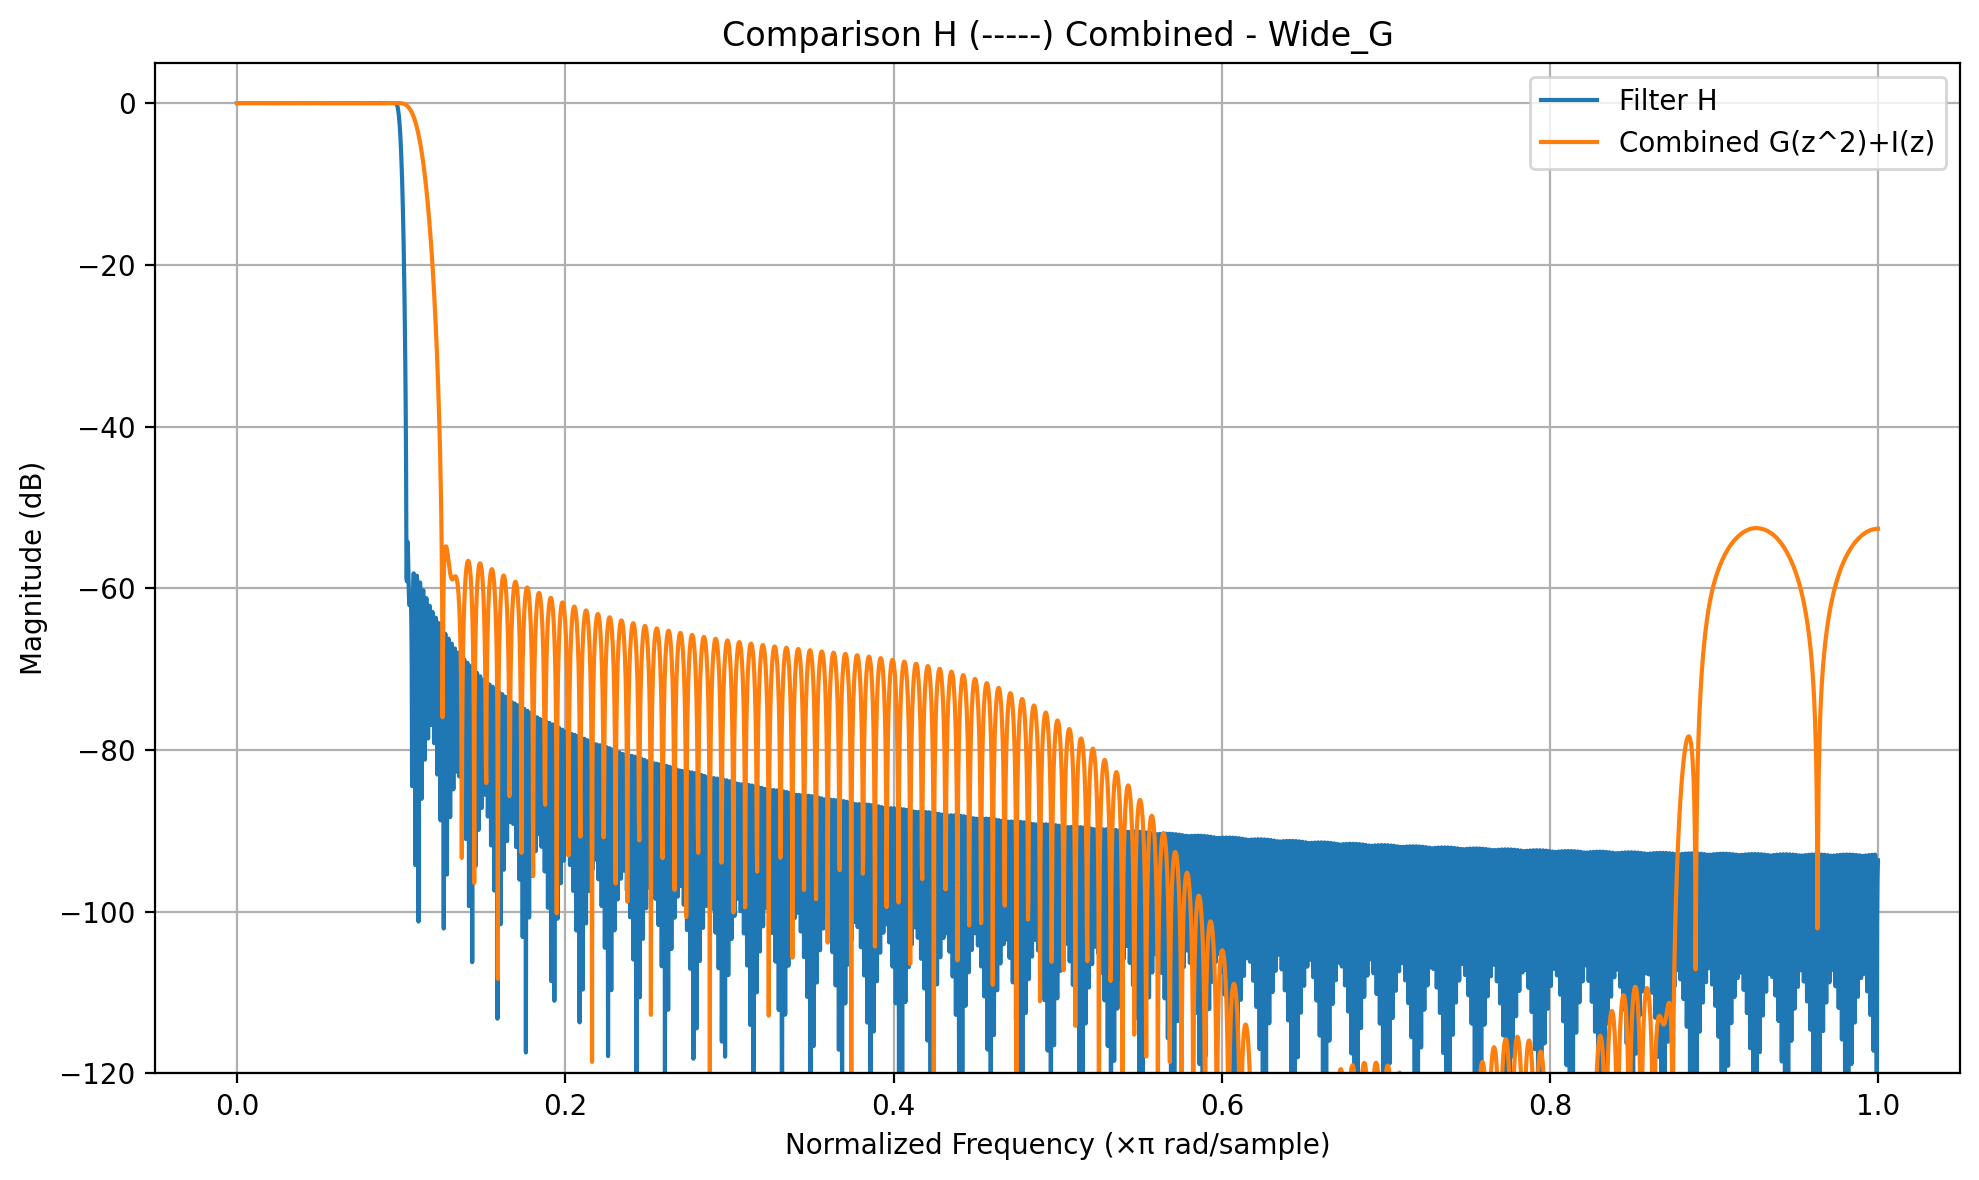

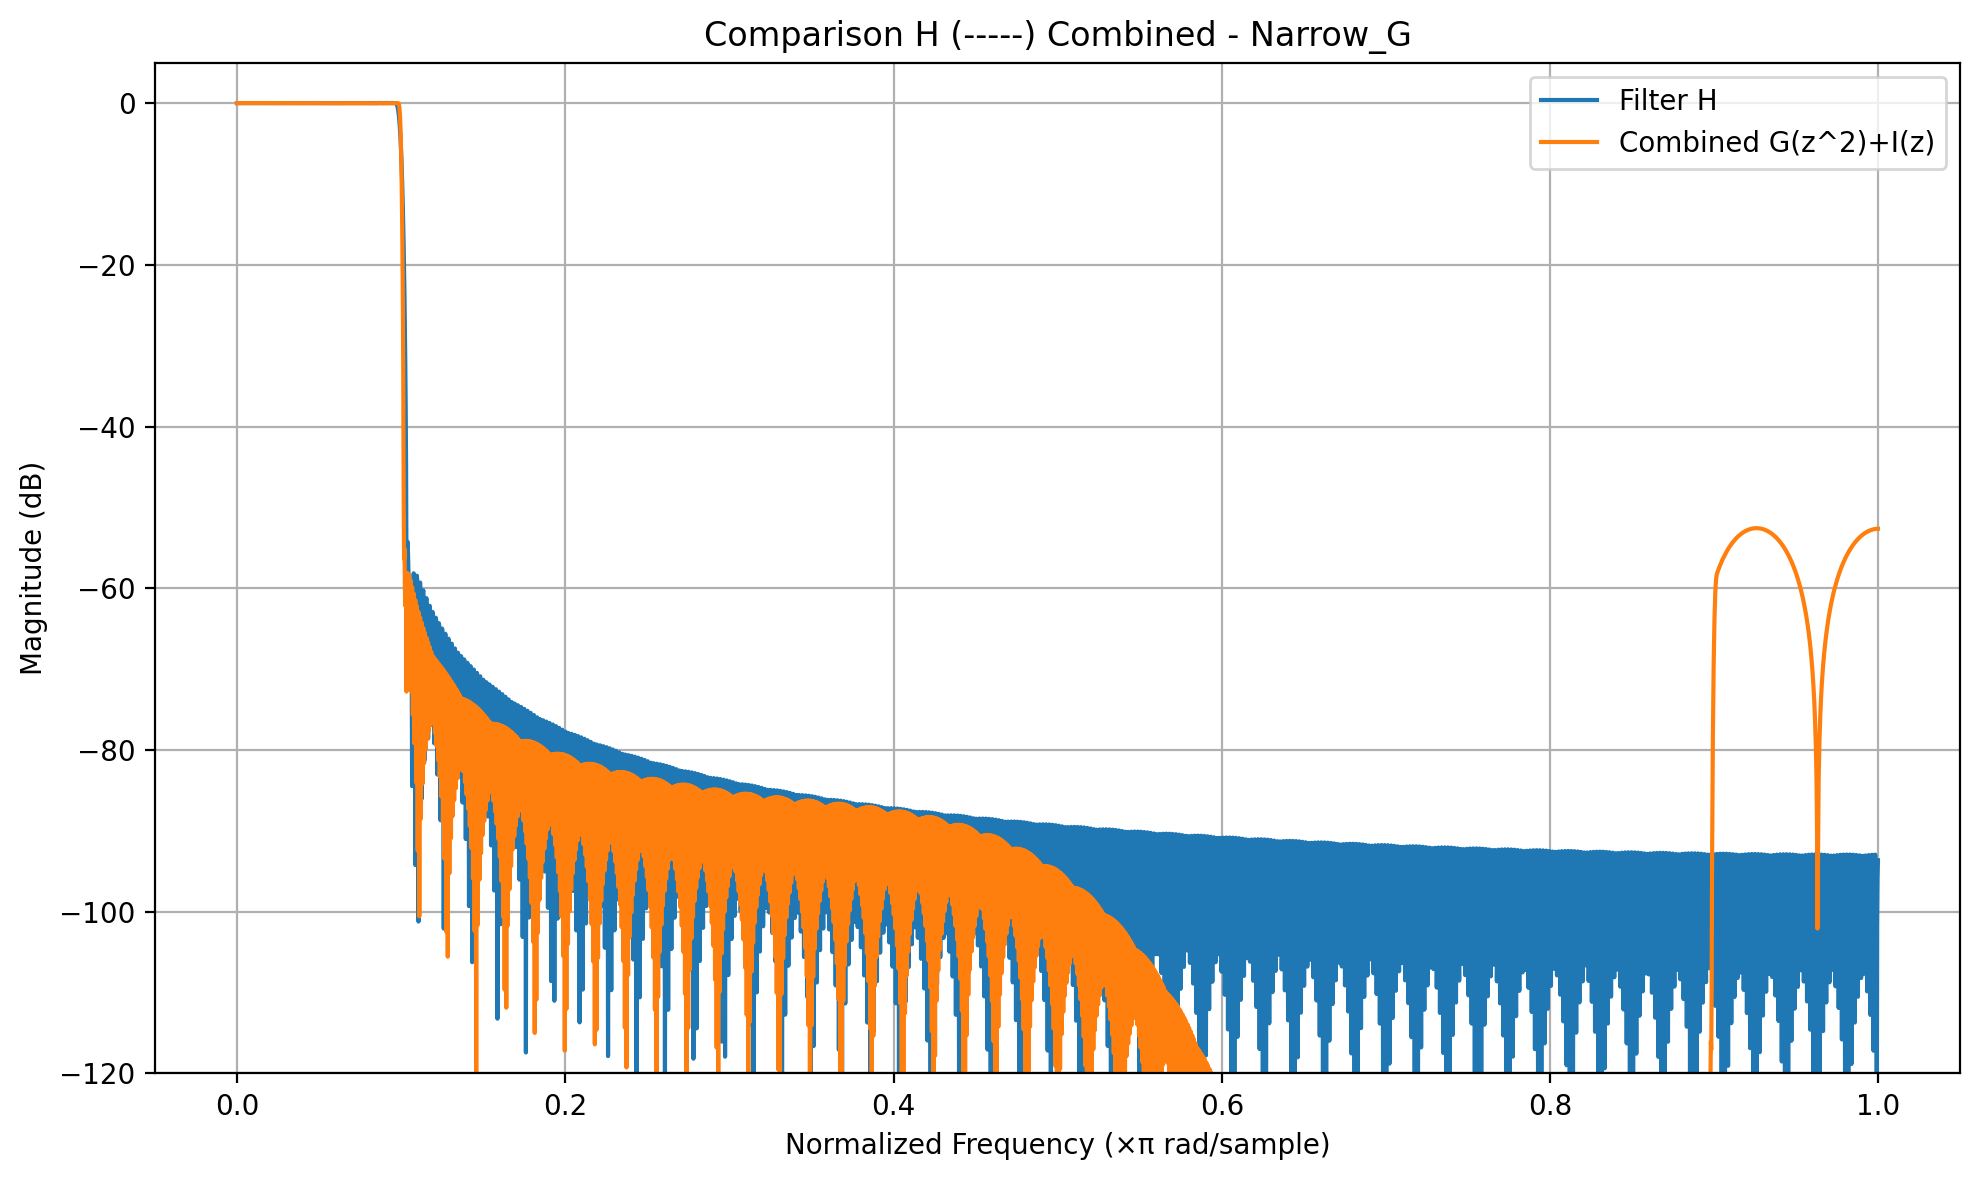

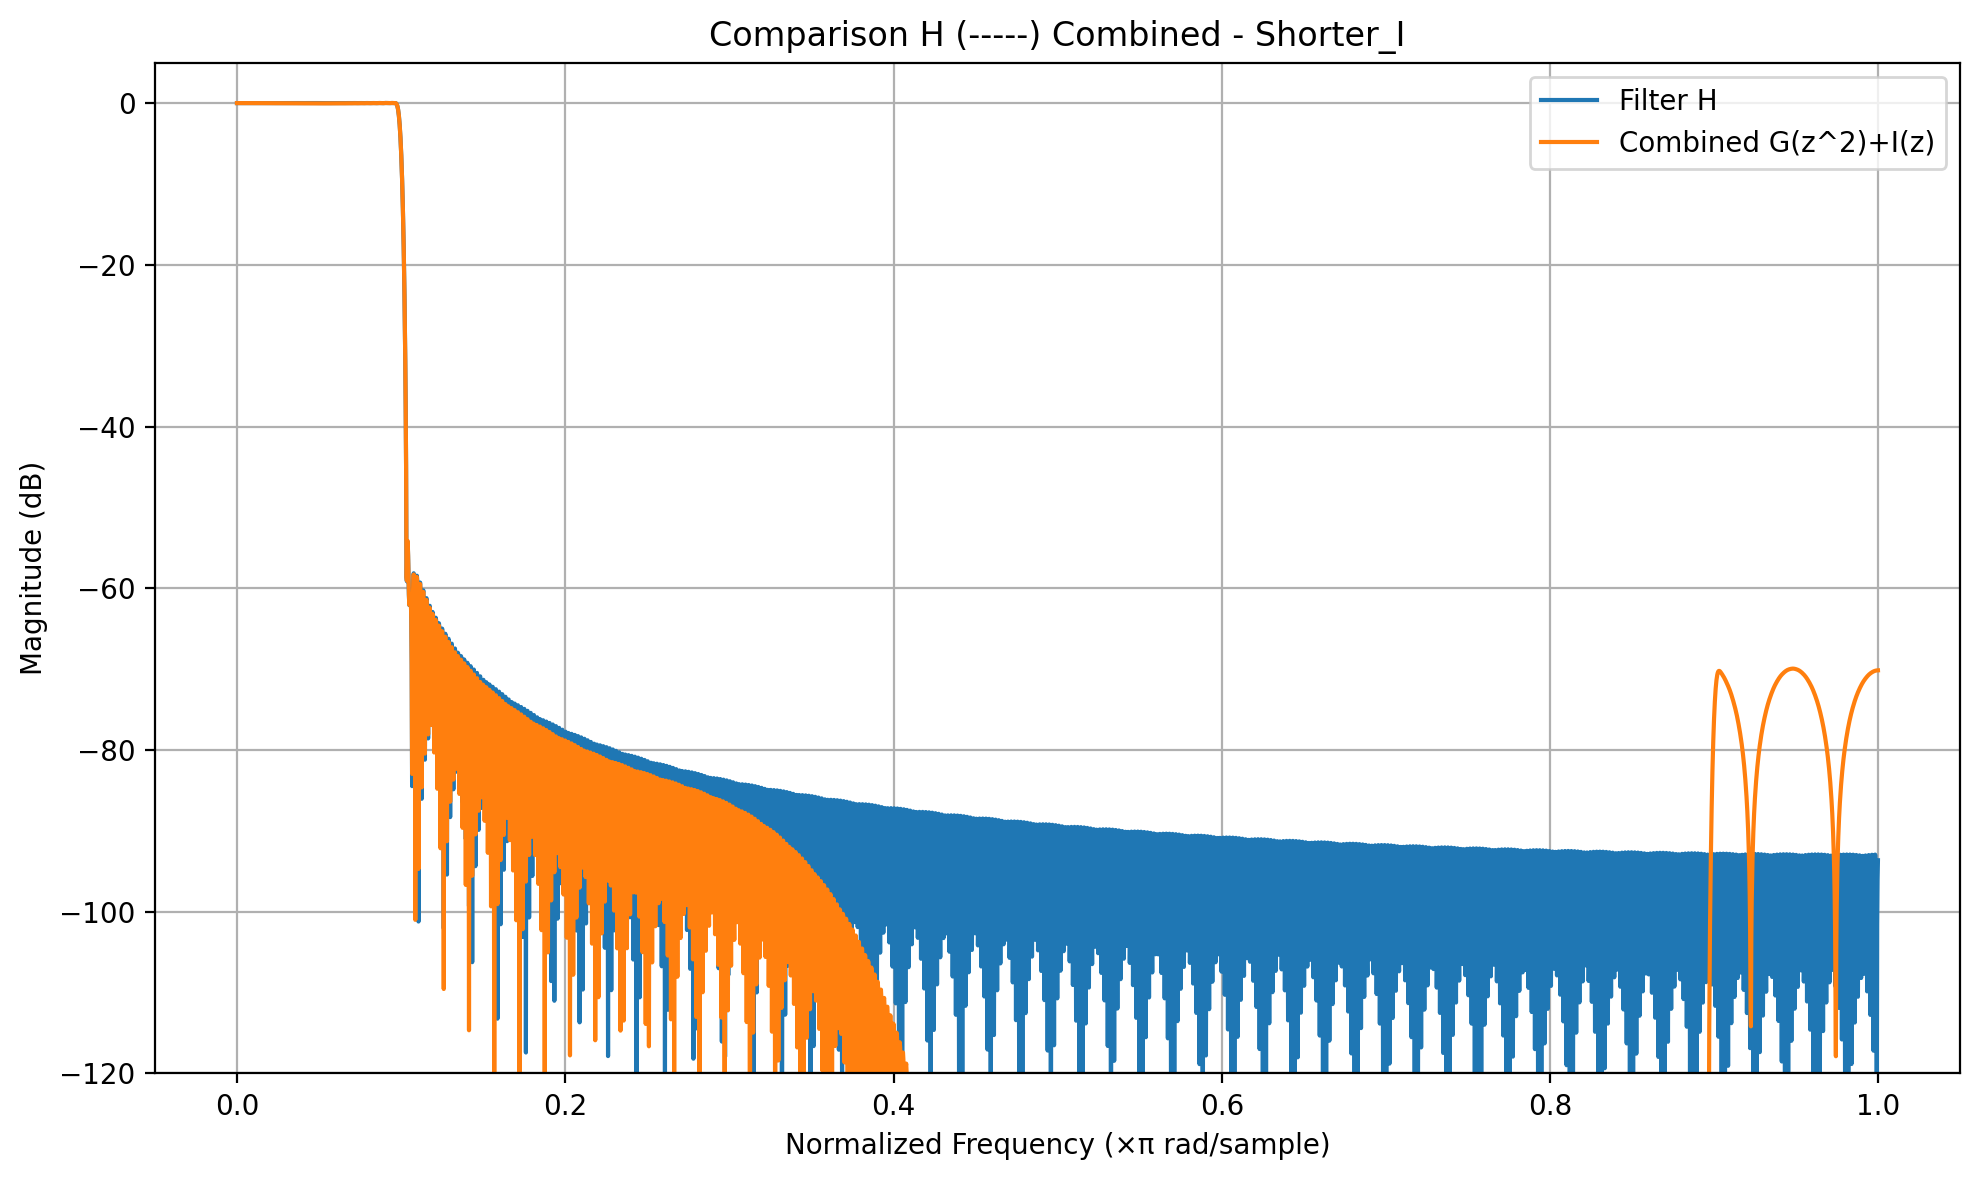

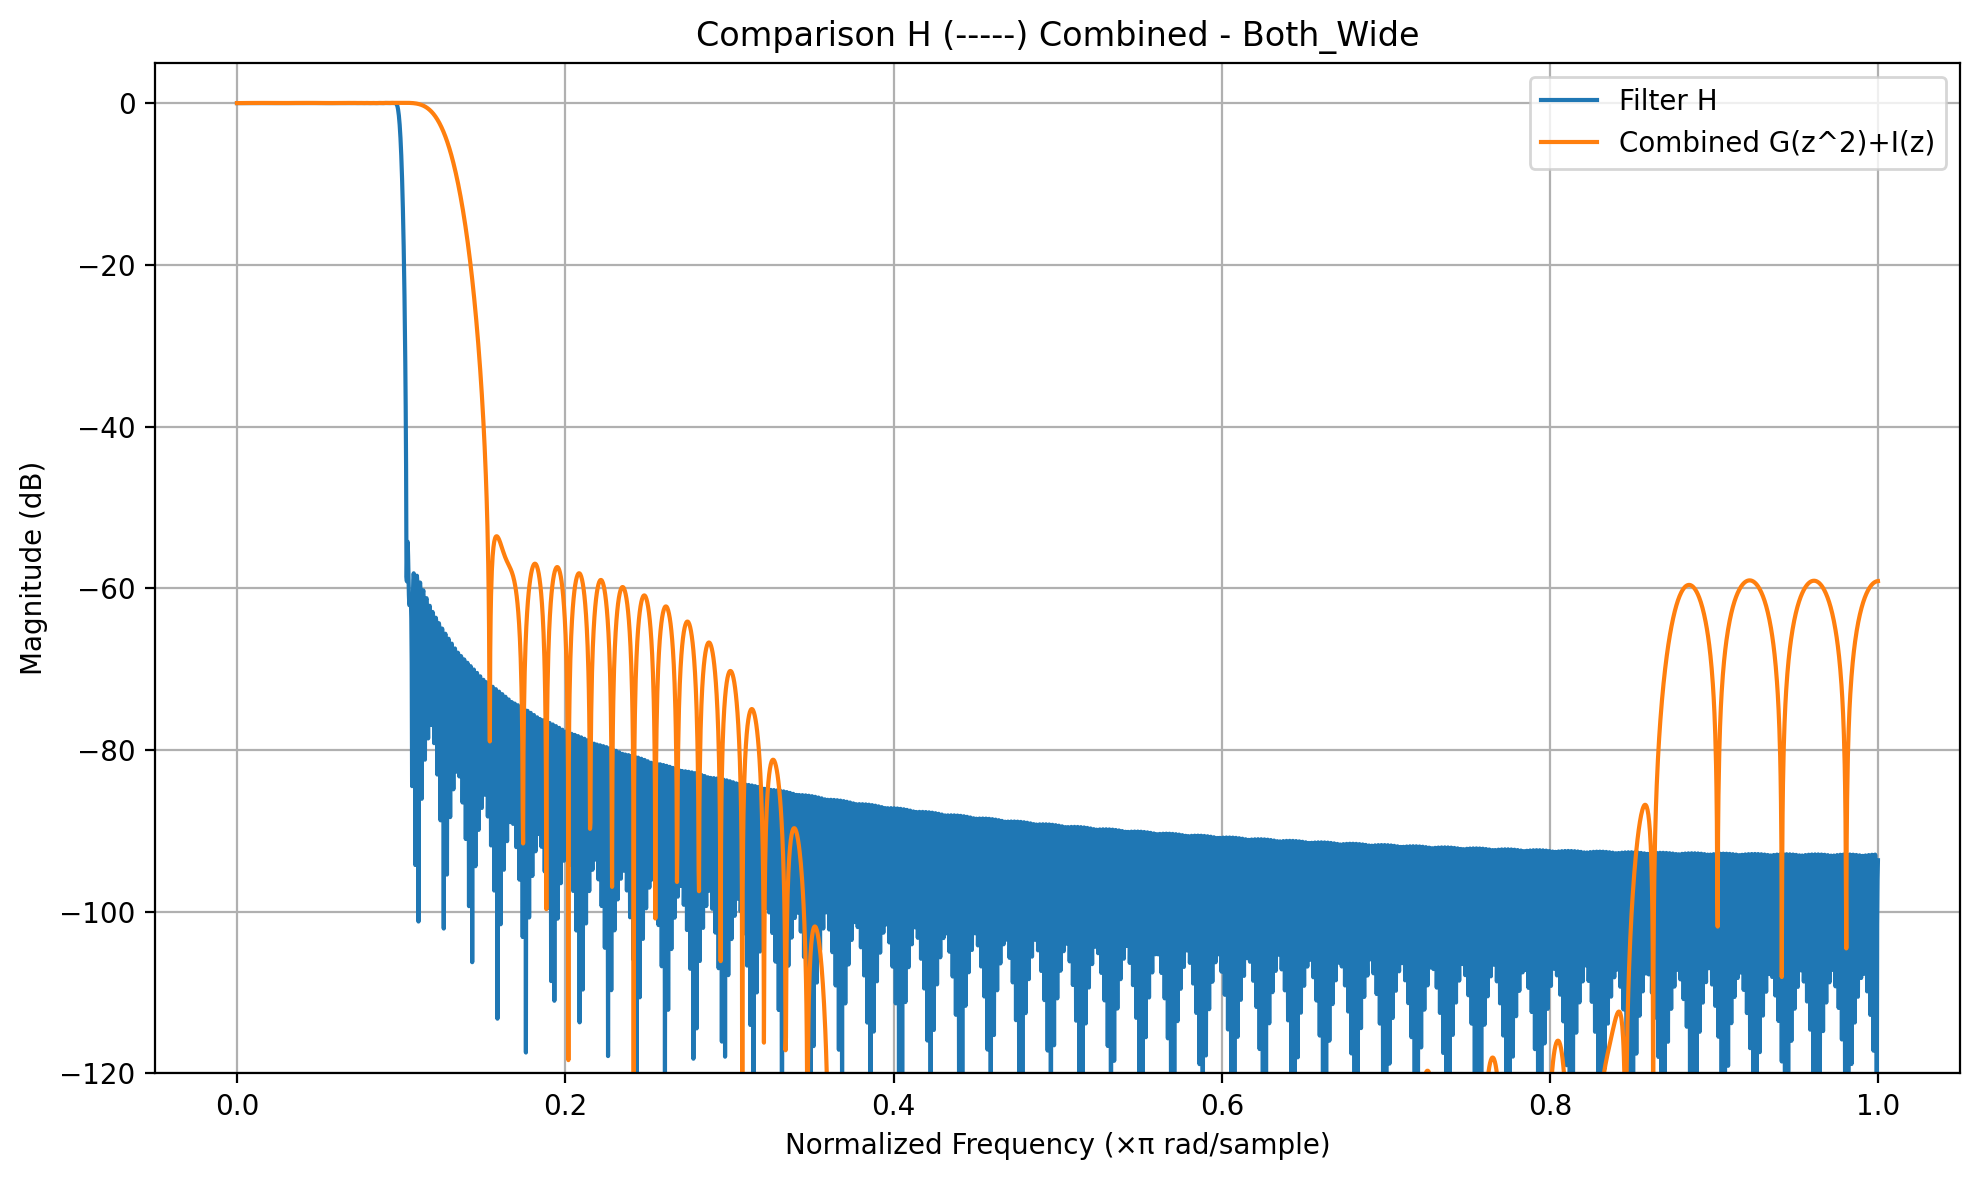

           numtaps_H  order_H  numtaps_G  numtaps_I  numtaps_combined  order_combined  order_reduction       mse_mag  stopband_att_H_dB
scenario                                                                                                                               
Original        1037     1036        519         27              1064            1063              -27  5.103405e-07          59.290098
Wide_G          1037     1036        139         27               304             303              733  8.882478e-03          59.290098
Narrow_G        1037     1036       1037         27              2100            2099            -1063  6.728139e-05          59.290098
Shorter_I       1037     1036        519         41              1078            1077              -41  6.520379e-07          59.290098
Both_Wide       1037     1036         75         51               200             199              837  2.401824e-02          59.290098


In [1]:

import os
import numpy as np
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt
import pandas as pd
def design_fir(wp, ws):
    transition = ws - wp
    N = int(np.ceil(6.6 * np.pi / transition))
    if N % 2 == 0:
        N += 1
    numtaps = N
    wc = (wp + ws) / 2
    h = firwin(numtaps=numtaps, cutoff=wc, window='hamming', pass_zero=True)
    return h, wc, numtaps
def upsample_by_2(h):
    out = np.zeros(len(h) * 2)
    out[::2] = h
    return out
scenarios = [
    {"name": "Original", "wp_G": 0.18, "ws_G": 0.22, "wp_I": 0.09, "ws_I": 0.89},
    {"name": "Wide_G", "wp_G": 0.15, "ws_G": 0.30, "wp_I": 0.09, "ws_I": 0.89},
    {"name": "Narrow_G", "wp_G": 0.19, "ws_G": 0.21, "wp_I": 0.09, "ws_I": 0.89},
    {"name": "Shorter_I", "wp_G": 0.18, "ws_G": 0.22, "wp_I": 0.09, "ws_I": 0.60},
    {"name": "Both_Wide", "wp_G": 0.12, "ws_G": 0.40, "wp_I": 0.09, "ws_I": 0.50}
]
wp_H = 0.09
ws_H = 0.11
h_H, wc_H, numtaps_H = design_fir(wp_H, ws_H)
w_H, H_H = freqz(h_H, worN=4096)
results = []
os.makedirs('/mnt/data/multistage_results', exist_ok=True)
for s in scenarios:
    h_G, wc_G, numtaps_G = design_fir(s["wp_G"], s["ws_G"])
    h_I, wc_I, numtaps_I = design_fir(s["wp_I"], s["ws_I"])
    h_G_up = upsample_by_2(h_G)
    h_comb = np.convolve(h_G_up, h_I)
    w_comb, H_comb = freqz(h_comb, worN=4096)
    min_len = min(len(H_H), len(H_comb))
    mse = np.mean((np.abs(H_H[:min_len]) - np.abs(H_comb[:min_len]))**2)
    order_H = len(h_H) - 1
    order_comb = len(h_comb) - 1
    order_reduction = order_H - order_comb
    stopband_start_idx = np.argmax((w_H / np.pi) > ws_H)
    stopband_db_H = 20 * np.log10(np.abs(H_H[stopband_start_idx:]) + 1e-20)
    stopband_att_H = -np.max(stopband_db_H)
    results.append({
        "scenario": s["name"],
        "numtaps_H": len(h_H),
        "order_H": order_H,
        "numtaps_G": len(h_G),
        "numtaps_I": len(h_I),
        "numtaps_combined": len(h_comb),
        "order_combined": order_comb,
        "order_reduction": order_reduction,
        "mse_mag": mse,
        "stopband_att_H_dB": stopband_att_H
    })
    plt.figure(figsize=(10,6), dpi=200)
    plt.plot(w_H/np.pi, 20*np.log10(np.abs(H_H)+1e-20), label='Filter H')
    plt.plot(w_comb/np.pi, 20*np.log10(np.abs(H_comb)+1e-20), label='Combined G(z^2)+I(z)')
    plt.title(f'Comparison H (-----) Combined - {s["name"]}')
    plt.xlabel('Normalized Frequency (×π rad/sample)')
    plt.ylabel('Magnitude (dB)')
    plt.ylim([-120,5])
    plt.grid(True)
    plt.legend()
    fname = f'compare_{s["name"]}.png'
    plt.tight_layout()
    plt.savefig(fname)
    plt.close()


    plt.figure(figsize=(10,6), dpi=200)
    plt.plot(w_H/np.pi, 20*np.log10(np.abs(H_H)+1e-20), label='Filter H')
    plt.plot(w_comb/np.pi, 20*np.log10(np.abs(H_comb)+1e-20), label='Combined G(z^2)+I(z)')
    plt.title(f'Comparison H (-----) Combined - {s["name"]}')
    plt.xlabel('Normalized Frequency (×π rad/sample)')
    plt.ylabel('Magnitude (dB)')
    plt.ylim([-120,5])
    plt.grid(True)
    plt.legend()
    fname = f'compare_{s["name"]}.png'
    plt.tight_layout()
    plt.show()




df = pd.DataFrame(results).set_index('scenario')
df.to_csv('summary.csv')
print(df.to_string())
